In [124]:
from FSC import *
import mrcfile
import time
import pandas as pd
import os
from resolution_measure_mrc import *
import seaborn as sns
import matplotlib.pyplot as plt

figs_dir = '/Users/atk42/OneDrive - Yale University/Lab/Projects/TEM_tomo/fig_panels/'
thick_pal={'1000nm':'#fe4a49','750nm':'#2ab7ca','500nm':'#fed766'}

def import_fsc_results(output_dir, tomo_lst, num_angs, max_angs, constant_density = False):
    df = pd.read_csv(tomo_lst)
    all_fsc = dict()
    #pd.DataFrame()
    for ref in ['a','b']:
        all_fsc[ref] = pd.DataFrame()
        for index,row in df.iterrows():
            proj = 'microscopy_%i' % int(row['MPID'])
            tomo = row['Tomogram']
            thickness = row['Thickness']
            pixel_size = row['Pixel Size bin 4 (nm)']
        
            for idx,num_ang in enumerate(num_angs):
                if constant_density:
                    max_angs_load = [max_angs[idx]]
                else:
                    max_angs_load = max_angs
                for max_ang in max_angs_load:
                    if num_ang == 121 and max_ang == 10:
                        continue
                    ofn = os.sep.join([output_dir, 'FSC3D_ref%s_%s_%s_%i-limited[%.1f_-%.1f].csv' % (ref, thickness, tomo,num_ang,max_ang,max_ang)])
                    fsc_df = pd.read_csv(ofn,header=None,names = ['z','x','y','res','mean','corr'])
                    fsc_df['thickness'] = thickness
                    fsc_df['pixel_size'] = float(pixel_size)
                    fsc_df['name'] = tomo
                    fsc_df['num_ang'] = int(num_ang)
                    fsc_df['max_ang'] = int(max_ang)
                    fsc_df['plane'] = '3d'
                    #fsc_df['fsc_resolution'] = [float(i[0:6]) for i in fsc_df['res'].values]
                    fsc_df['fsc_resolution'] = [float(i) for i in fsc_df['res'].values]
                    fsc_df['correlation'] = [float(i) for i in fsc_df['corr'].values]
                    all_fsc[ref] = pd.concat([all_fsc[ref], fsc_df])
    return all_fsc


def import_fsc_results_2D(output_dir, tomo_lst, num_angs, max_angs, plane='beam'):
    df = pd.read_csv(tomo_lst)
    all_fsc_2D = pd.DataFrame()
    for index,row in df.iterrows():
        proj = 'microscopy_%i' % int(row['MPID'])
        tomo = row['Tomogram']
        thickness = row['Thickness']
        pixel_size = row['Pixel Size bin 4 (nm)']
        for plane in ['beam','tilt','edge']:
            for num_ang in num_angs:
                for max_ang in max_angs:
                    if num_ang == 121 and max_ang == 10:
                        continue
                    ofn = os.sep.join([output_dir, 'FSC2D_%s_%s_%i-limited[%.1f_-%.1f].csv' % (thickness, tomo,num_ang,max_ang,max_ang)])
                    fsc_df = pd.read_csv(ofn,header=None,names = ['z','x','y','res','mean'])
                    fsc_df['thickness'] = thickness
                    fsc_df['pixel_size'] = pixel_size
                    fsc_df['name'] = tomo
                    fsc_df['num_ang'] = num_ang
                    fsc_df['max_ang'] = max_ang
                    fsc_df['plane'] = plane
                    fsc_df['mean_pix'] = [float(i) for i in fsc_df['mean'].values]
                    fsc_df['fsc_resolution'] = [float(i) for i in fsc_df['res'].values]
                    #fsc_df['correlation'] = [float(i) for i in fsc_df['corr'].values]
                    all_fsc_2D = pd.concat([all_fsc_2D, fsc_df])
    return all_fsc_2D

def average_dfs(df1, df2, exclude_cols = None):

    # Identifying numeric columns
    numeric_cols = df1.select_dtypes(include=[np.number]).columns

    # Averaging numeric columns
    average_df = (df1[numeric_cols] + df2[numeric_cols]) / 2

    # Handling non-numeric columns
    for col in df1.columns:
        if col not in exclude_cols:
            if col not in numeric_cols:
                if (df1[col] == df2[col]).all():
                    average_df[col] = df1[col]
                else:
                    raise ValueError(f"Non-matching values found in column {col}")
    return average_df

In [136]:
# 1.5 deg plot
####### Edit these params
num_angs = [121, 33, 21, 17, 11, 5]
max_angs = [10,20,30,40,50,60]

tomo_lst = 'tomo_lists/tomograms_lst - double_tilt_tomos_3.3k.csv'
output_dir_3k = 'results/240508_3.3k_8sub'
fscs_3k= import_fsc_results(output_dir_3k, tomo_lst, num_angs, max_angs)
all_fsc_3k = average_dfs(fscs_3k['a'],fscs_3k['b'], exclude_cols=['res','corr'])
all_fsc_3k = all_fsc_3k[all_fsc_3k['thickness'].isin(['500nm','750nm','1000nm'])]

tomo_lst_11k = 'tomo_lists/tomograms_lst - double_tilt_tomos_11k.csv'
output_dir_11k = 'results/240513_11k_16sub'
fscs_11k= import_fsc_results(output_dir_11k, tomo_lst_11k, num_angs, max_angs)
all_fsc_11k = average_dfs(fscs_11k['a'],fscs_11k['b'], exclude_cols=['res','corr'])
all_fsc_11k = all_fsc_11k[all_fsc_11k['thickness'].isin(['500nm','750nm','1000nm'])]

#all_fsc_const = import_fsc_results(output_dir, tomo_lst, num_angs, max_angs, constant_density = True)

###########

In [114]:
# Constant density plot
sns.set_theme(rc={'figure.figsize':(3,2),'lines.linewidth':0.8},style = 'ticks')
my_df = all_fsc_const
my_df.dropna(subset=['fsc_resolution'], inplace=True)
g = sns.pointplot(my_df,x='max_ang', y = 'fsc_resolution', hue='thickness', estimator='median',
            errorbar=None, 
            #errorbar = ('ci', 95),
            native_scale=True, dodge = 0.1, palette='coolwarm',
            log_scale = False,  markersize = 2, capsize = .4,
            err_kws={'linewidth':1})

theta_labels = ['±%s°' % ang for ang in max_angs]
g.set_xticks(max_angs)
g.set_xticklabels(theta_labels, rotation = 45)
handles, previous_labels = g.get_legend_handles_labels()
g.legend(handles=handles, title = 'Thickness',
         bbox_to_anchor=(.2, .5), loc='lower left',ncol=1)
g.legend(handles=handles, title = 'Thickness',
         bbox_to_anchor=(.5, .7), loc='lower left',ncol=1)
g.set_xlabel('Angular Range (1.5° Increments)')
g.set_ylabel('FSC Resolution (nm)')
#g.grid(axis='y', color = 'k', linewidth=0.5)
#g.set_ylim([10,g.get_ylim()[1]])
sns.despine()

mag = '3.3k'
#plt.savefig(figs_dir + 'const_density_series_%s.png' % mag, bbox_inches = 'tight')

NameError: name 'all_fsc_const' is not defined

500nm: 12.1 ± 1.4 nm
750nm: 13.2 ± 0.8 nm
1000nm: 15.0 ± 0.7 nm


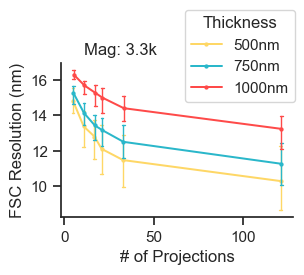

In [190]:
# Main Plot for FSC res vs # projections 
# Fig. 2b new
max_ang = 30
mag = '3.3k'
#mag = '11k'
if mag == '3.3k':
    my_df = all_fsc_3k
elif mag == '11k':
    my_df = all_fsc_11k
my_df = my_df[my_df['max_ang']==max_ang]

sns.set_theme(rc={'figure.figsize':(3,2),'lines.linewidth':0.8},style = 'ticks')

my_df = my_df[my_df['fsc_resolution']>0] # remove outlier cubes
g = sns.pointplot(my_df,x='num_ang', y = 'fsc_resolution', hue='thickness', estimator='median',
            errorbar=('pi',50), 
            #errorbar = ('ci', 95),
            native_scale=True, dodge = 0.1, palette=thick_pal,
            log_scale = False,  markersize = 2, capsize = .4,
            err_kws={'linewidth':1})

handles, previous_labels = g.get_legend_handles_labels()
g.legend(handles=handles, title = 'Thickness',
         bbox_to_anchor=(.5, .7), loc='lower left',ncol=1)
g.set_xlabel('# of Projections')
g.set_ylabel('FSC Resolution (nm)')
g.set_title('Mag: %s' % mag, ha='left', x = 0.1)
#g.grid(axis='y', color = 'k', linewidth=0.5)
#g.set_ylim([10,g.get_ylim()[1]])
sns.despine()

num_ang = 21
for thickness in my_df.thickness.unique():
    test_df = my_df[my_df.thickness == thickness]
    test_df = test_df[test_df.num_ang == num_ang]
    
    print('%s: %0.1f ± %0.1f nm' % (thickness,np.median(test_df.fsc_resolution.values),stats.iqr(test_df.fsc_resolution.values)/2))
plt.savefig(figs_dir + 'Numang_FSCres_thickness_3D_%s.png' % mag, bbox_inches = 'tight')


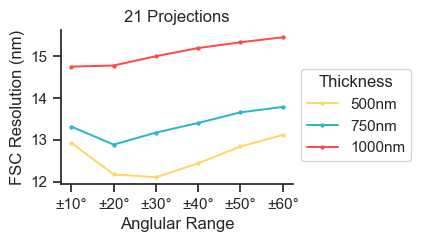

In [180]:
thickness = '750nm'
#max_ang = 30
num_ang = 21

theta_labels = ['±%s°' % ang for ang in max_angs]

mag = '3.3k'

if mag == '3.3k':
    my_df = all_fsc_3k
elif mag == '11k':
    my_df = all_fsc_11k

#my_df = my_df[my_df['thickness']==thickness]
#my_df = my_df[my_df['num_ang'].isin(num_angs)]
my_df = my_df[my_df['num_ang']==num_ang]

sns.set_theme(rc={'figure.figsize':(3,2),'lines.linewidth':0.8},style = 'ticks')
my_df = my_df[my_df['fsc_resolution']>0] # remove outlier cubes
g = sns.pointplot(my_df,x='max_ang', y = 'fsc_resolution', hue='thickness', estimator='median',
            errorbar=None, native_scale=True, dodge = 0, palette=thick_pal,
            log_scale = False,  markersize = 2, capsize = .2,
            err_kws={'linewidth':1})

handles, previous_labels = g.get_legend_handles_labels()
g.legend(handles=handles,  title = 'Thickness',
         bbox_to_anchor=(1, 0.1), loc='lower left',ncol=1)
g.set_xlabel('Anglular Range')
g.set_xticks(max_angs)
g.set_xticklabels(theta_labels)
g.set_ylabel('FSC Resolution (nm)')
g.set_title('%i Projections' % num_ang)
sns.despine()
plt.savefig(figs_dir + 'thetaRange_FSCres_Numang_%i_3D.png'%num_angs[0], bbox_inches = 'tight')

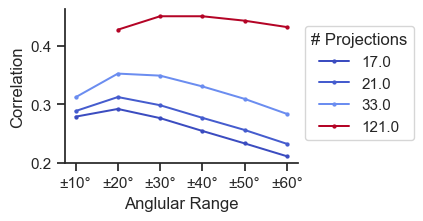

In [162]:
#Correlation plot examining angular range
thickness = '750nm'
#max_ang = 60
#num_ang = 33
#num_angs = [121, 33, 21, 17]
theta_labels = ['±%s°' % ang for ang in max_angs]

mag = '3.3k'

if mag == '3.3k':
    my_df = all_fsc_3k
elif mag == '11k':
    my_df = all_fsc_11k

my_df = my_df[my_df['thickness']==thickness]
my_df = my_df[my_df['num_ang'].isin(num_angs)]

sns.set_theme(rc={'figure.figsize':(3,2),'lines.linewidth':0.8},style = 'ticks')

my_df.dropna(subset=['correlation'], inplace=True)
g = sns.pointplot(my_df,x='max_ang', y='correlation', hue='num_ang', estimator='median',
            errorbar=None, native_scale=True, dodge = 0, palette='coolwarm',
            log_scale = False,  markersize = 2, capsize = .2,
            err_kws={'linewidth':1})

handles, previous_labels = g.get_legend_handles_labels()
g.legend(handles=handles,  title = '# Projections',
         bbox_to_anchor=(1, 0.1), loc=
         'lower left',ncol=1)
g.set_xlabel('Anglular Range')
g.set_xticks(max_angs)
g.set_xticklabels(theta_labels)
g.set_ylabel('Correlation')
sns.despine()
plt.savefig(figs_dir + 'thetaRange_Corr_Numang_3D_'+thickness+'.png', bbox_inches = 'tight')

In [160]:
max_ang = 30
num_ang = 21
thickness = '750nm'

my_df = all_fsc_3k

my_df = my_df[my_df['max_ang']==max_ang]
my_df = my_df[my_df['num_ang']==num_ang]
my_df = my_df[my_df['thickness']==thickness]

heatmapdata = my_df.pivot(index = 'y', columns ='x', 
                          values = 'fsc_resolution')
sns.set_theme(rc={'figure.figsize':(4,3),'lines.linewidth':0.8},style = 'ticks')
g = sns.heatmap(heatmapdata, cmap='hsv', vmin=10, vmax=50)
#g.axis('equal')

#plt.savefig(figs_dir + 'heatmap_FSC3DvsXY_'+thickness+'.png', bbox_inches = 'tight')

ValueError: Index contains duplicate entries, cannot reshape

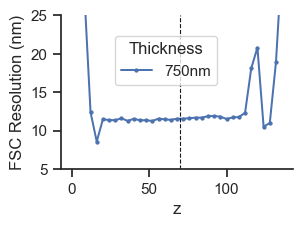

In [ ]:
# Plot res vs z with 2D fsc
num_angs = [121, 33, 21, 17, 11, 5]
max_angs = [10,20,30,40,50,60]
output_dir = '240309_baRef_FSC2D_subsamp4_beam'
tomo_lst = 'tomograms_lst - double_tilt_tomos.csv'

all_fsc_2D = import_fsc_results_2D(output_dir, tomo_lst, num_angs, max_angs)

# Compare over y locations 
# Fig. 2b new
max_ang = 30
num_ang = 21
thickness = '750nm'

my_df = all_fsc_2D
my_df = my_df[my_df['thickness']==thickness]
my_df = my_df[my_df['max_ang']==max_ang]
my_df = my_df[my_df['num_ang']==num_ang]
my_df.dropna(subset=['mean'], inplace=True)

sns.set_theme(rc={'figure.figsize':(3,2),'lines.linewidth':0.8},style = 'ticks')
g = sns.pointplot(my_df,x='z', y = 'fsc_resolution', estimator='median',
            errorbar=('pi',50), native_scale=True, hue='thickness',
            log_scale = False,  markersize = 2, capsize = .2,
            err_kws={'linewidth':1})


g.set_ylim([5,25])

handles, previous_labels = g.get_legend_handles_labels()
g.legend(handles=handles, title = 'Thickness',
         bbox_to_anchor=(.2, .5), loc='lower left',ncol=1)
#g.set_xlabel('x Position')
g.set_ylabel('FSC Resolution (nm)')

plt.axvline(x=140/2, color='k', linestyle='--')
sns.despine()

plt.savefig(figs_dir + 'FSC2DvsZ_'+thickness+'.png', bbox_inches = 'tight')

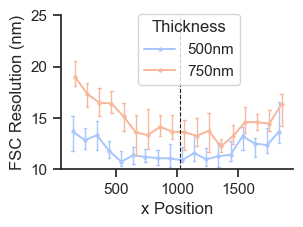

In [ ]:
# Compare over x locations 
# Fig. 2b new
max_ang = 30
num_ang = 21

my_df = all_fsc
my_df = my_df[my_df['max_ang']==max_ang]
my_df = my_df[my_df['num_ang']==num_ang]
# Remove edge effects
my_df = my_df[my_df.x >= 100]
my_df = my_df[my_df.x <= 1900]
my_df = my_df[my_df.y >= 100]
my_df = my_df[my_df.y <= 1900]

sns.set_theme(rc={'figure.figsize':(3,2),'lines.linewidth':0.8},style = 'ticks')

g = sns.pointplot(my_df,x='x', y = 'fsc_resolution', hue='thickness', estimator='median',
            errorbar=('pi',50), native_scale=True, dodge = 0.2, palette='coolwarm',
            log_scale = False,  markersize = 2, capsize = .2,
            err_kws={'linewidth':1})
g.set_ylim([10,25])

handles, previous_labels = g.get_legend_handles_labels()
g.legend(handles=handles, title = 'Thickness',
         bbox_to_anchor=(.3, .5), loc='lower left',ncol=1)
g.set_xlabel('x Position')
g.set_ylabel('FSC Resolution (nm)')

plt.axvline(x=2048/2, color='k', linestyle='--')
sns.despine()

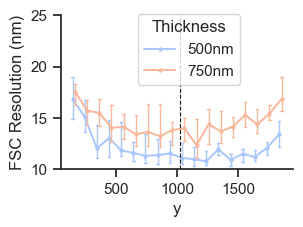

In [ ]:
# Compare over y locations 
# Fig. 2b new
max_ang = 30
num_ang = 21

my_df = all_fsc
my_df = my_df[my_df['max_ang']==max_ang]
my_df = my_df[my_df['num_ang']==num_ang]

# Remove edge effects
my_df = my_df[my_df.x >= 100]
my_df = my_df[my_df.x <= 1900]
my_df = my_df[my_df.y >= 100]
my_df = my_df[my_df.y <= 1900]
sns.set_theme(rc={'figure.figsize':(3,2),'lines.linewidth':0.8},style = 'ticks')

g = sns.pointplot(my_df,x='y', y = 'fsc_resolution', hue='thickness', estimator='median',
            errorbar=('pi',50), native_scale=True, dodge = 0.2, palette='coolwarm',
            log_scale = False,  markersize = 2, capsize = .2,
            err_kws={'linewidth':1})
g.set_ylim([10,25])

handles, previous_labels = g.get_legend_handles_labels()
g.legend(handles=handles, title = 'Thickness',
         bbox_to_anchor=(.3, .5), loc='lower left',ncol=1)
#g.set_xlabel('x Position')
g.set_ylabel('FSC Resolution (nm)')

plt.axvline(x=2048/2, color='k', linestyle='--')
sns.despine()

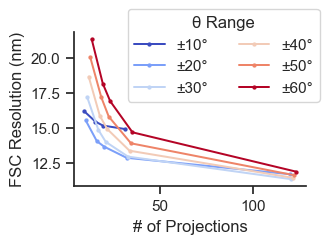

In [ ]:
thickness = '500nm'
max_ang = 60
num_ang = 33
num_angs = [121, 33, 21, 17, 11]
theta_labels = ['±%s°' % ang for ang in max_angs]

my_df = all_fsc
my_df = all_fsc[all_fsc['thickness']==thickness]
my_df = all_fsc[all_fsc['num_ang'].isin(num_angs)]

sns.set_theme(rc={'figure.figsize':(3,2),'lines.linewidth':0.8},style = 'ticks')

g = sns.pointplot(my_df,x='num_ang', y = 'fsc_resolution', hue='max_ang', estimator='median',
            #errorbar=('pi',50), 
            errorbar = None ,native_scale=True, dodge = 1, palette='coolwarm',
            log_scale = False,  markersize = 2, capsize = .2,
            err_kws={'linewidth':1})

handles, previous_labels = g.get_legend_handles_labels()
g.legend(handles=handles, labels=theta_labels, title = 'θ Range',
         bbox_to_anchor=(.2, .5), loc='lower left',ncol=2)
g.set_xlabel('# of Projections')
g.set_ylabel('FSC Resolution (nm)')
sns.despine()

plt.savefig(figs_dir + 'Numang_FSCres_thetaRange_3D.png', bbox_inches = 'tight')


In [ ]:
# Working with file structure to analyze multiple datasets
# Look at diff 2d Planes

#data_path = '/Users/atk42/OneDrive - Yale University/Lab/Projects/TEM_tomo/tomo_data'
#data_path = '/home/atk13/new_project_20471'
#tomo_lst = 'tomograms_lst - Local Tomograms for FSC.csv'
tomo_lst = 'tomograms_lst - double_tilt_tomos.csv'

df = pd.read_csv(tomo_lst)

output_dir = '240207_dtFSC2D_'
all_fsc = pd.DataFrame()
for index,row in df.iterrows():
	proj = 'microscopy_%i' % int(row['MPID'])
	tomo = row['Tomogram']
	thickness = row['Thickness']
	pixel_size = row['Pixel Size bin 4 (nm)']

	#tomo_path = os.sep.join([data_path, proj, 'processed_data',tomo,'txbr-backprojection','limited-bin4'])
	for plane in ['beam','tilt','edge']:
		output_dir = '240207_dtFSC2D_%s' % plane
		for num_ang in num_angs:
			for max_ang in max_angs:
				ofn = os.sep.join([output_dir, 'dtFSC2D_%s_%s_%i-limited[%.1f_-%.1f].csv' % (thickness, tomo,num_ang,max_ang,max_ang)])
				fsc_df = pd.read_csv(ofn,header=None,names = ['z','x','y','res','mean'])
				#print('Loading FSC for %s' % ofn)
				fsc_df['thickness'] = thickness
				fsc_df['pixel_size'] = pixel_size
				fsc_df['name'] = tomo
				fsc_df['num_ang'] = num_ang
				fsc_df['max_ang'] = max_ang
				fsc_df['plane'] = plane
				#fsc_df['fsc_resolution'] = [float(i[0:6]) for i in fsc_df['res'].values]
				fsc_df['fsc_resolution'] = [float(i) for i in fsc_df['res'].values]
				all_fsc = pd.concat([all_fsc, fsc_df])


# add 3D
tomo_lst = 'tomograms_lst - double_tilt_tomos.csv'

df = pd.read_csv(tomo_lst)
output_dir = '240207_dtFSC3D_100cube_subsamp'
#all_fsc = pd.DataFrame()
for index,row in df.iterrows():
	proj = 'microscopy_%i' % int(row['MPID'])
	tomo = row['Tomogram']
	thickness = row['Thickness']
	pixel_size = row['Pixel Size bin 4 (nm)']

	#tomo_path = os.sep.join([data_path, proj, 'processed_data',tomo,'txbr-backprojection','limited-bin4'])
	for num_ang in num_angs:
		for max_ang in max_angs:
			#ofn = os.sep.join([output_dir, 'FSC3D_%s_%s_%i-limited[%.1f_-%.1f].csv' % (thickness, tomo,num_ang,max_ang,max_ang)])
			ofn = os.sep.join([output_dir, 'dtFSC3D_%s_%s_%i-limited[%.1f_-%.1f].csv' % (thickness, tomo,num_ang,max_ang,max_ang)])
			fsc_df = pd.read_csv(ofn,header=None,names = ['z','x','y','res','mean'])
			#print('Loading FSC for %s' % ofn)
			fsc_df['thickness'] = thickness
			fsc_df['pixel_size'] = pixel_size
			fsc_df['name'] = tomo
			fsc_df['num_ang'] = num_ang
			fsc_df['max_ang'] = max_ang
			fsc_df['plane'] = '3D'
			#fsc_df['fsc_resolution'] = [float(i[0:6]) for i in fsc_df['res'].values]
			fsc_df['fsc_resolution'] = [float(i) for i in fsc_df['res'].values]
			all_fsc = pd.concat([all_fsc, fsc_df])


FileNotFoundError: [Errno 2] No such file or directory: '240207_dtFSC2D_beam/dtFSC2D_750nm_MouseCerebellum_A3S1_SA3.3k_de64_tomo10_121-limited[60.0_-60.0].csv'

In [ ]:
np.unique(all_fsc['z'].values)

array([70])

<Axes: xlabel='num_ang', ylabel='fsc_resolution'>

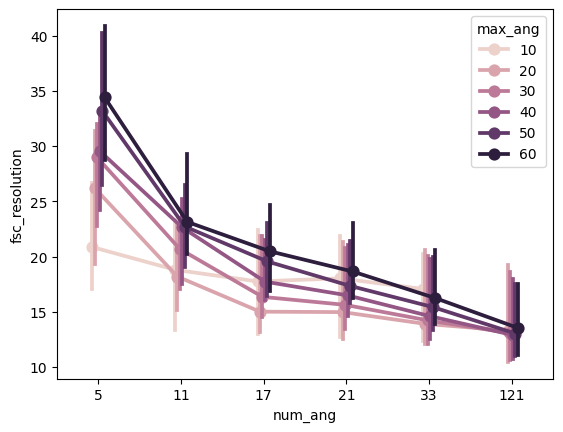

In [ ]:
thickness = '750nm'
plane = 'edge'
max_ang = 60
num_ang = 33

my_df = all_fsc
my_df = all_fsc[all_fsc['thickness']==thickness]
#my_df = my_df[my_df['max_ang']==max_ang]
#my_df = my_df[my_df['z'] == 100]
#my_df = my_df[my_df['num_ang']==num_ang]
#my_df = my_df[my_df['plane']==plane]
#sns.swarmplot(my_df,x='thickness', y = 'fsc_resolution')

#my_df = my_df[my_df['z'] == 50]
#my_df = my_df[my_df['y'] == 1050]

#sns.pointplot(my_df,x='num_ang', y = 'correlation', hue='max_ang', estimator='median',errorbar=('pi',50), dodge = True)
sns.pointplot(my_df,x='num_ang', y = 'fsc_resolution', hue='max_ang', estimator='median',errorbar=('pi',50), dodge = True)

#sns.violinplot(my_df,x='num_ang', y = 'fsc_resolution', hue='max_ang', dodge=True)

#plt.ylim([0,50])
#sns.swarmplot(my_df,x='z', y = 'fsc_resolution')
#sns.violinplot(my_df,x='z', y = 'fsc_resolution')
#sns.swarmplot(my_df,x='x', y = 'fsc_resolution')

#my_df = my_df[my_df['num_ang']==num_ang]
#sns.pointplot(my_df,x='x', y = 'fsc_resolution', hue='max_ang', estimator='median',errorbar=('pi',50), dodge = True)


#sns.swarmplot(my_df,x='x', y = 'fsc_resolution', hue='max_ang',  dodge = True)
#sns.violinplot(my_df,x='plane', y = 'fsc_resolution', hue='max_ang')
#print(my_df.x)

#plt.ylim([0,45])

Text(0.5, 1.0, '500nm thickness 3d plane')

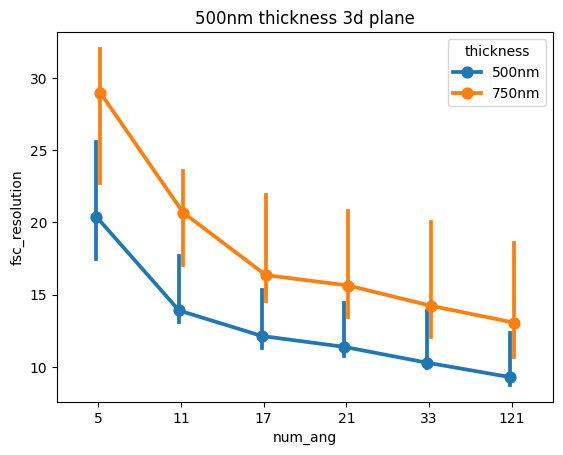

In [ ]:
max_ang = 30
#my_df = my_df[my_df['z'] == 50]
my_df = all_fsc[all_fsc['max_ang']==max_ang]

g= sns.pointplot(my_df,x='num_ang', y = 'fsc_resolution', hue='thickness',  estimator='median',errorbar=('pi',50), dodge = True)
#g= sns.pointplot(my_df,x='num_ang', y = 'correlation', hue='thickness',  estimator='median',errorbar=('pi',50), dodge = True)
#g.set_yscale("log")
plt.title('%s thickness %s plane' % (thickness, plane))

/var/folders/vt/w6ggr1fn7ys7zyrbpq3d7ls5gbhsxz/T/ipykernel_6496/261843216.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  my_df.dropna(subset=['correlation'], inplace=True)


Text(0.5, 1.0, '500nm thickness')

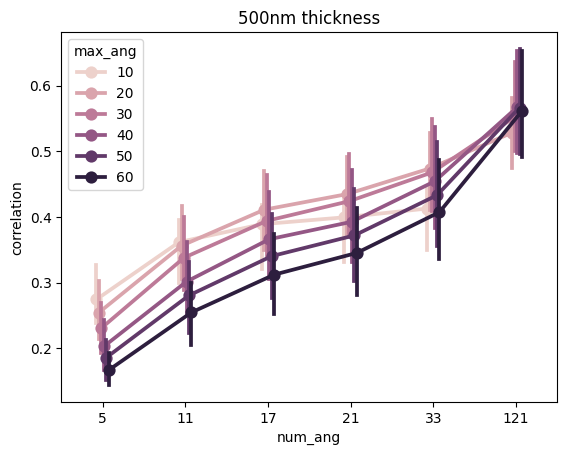

In [ ]:
thickness = '500nm'
#max_ang = 40
my_df = all_fsc[all_fsc['thickness']==thickness]
#my_df = my_df[my_df['max_ang']==max_ang]
my_df.dropna(subset=['correlation'], inplace=True)
#g= sns.pointplot(my_df,x='num_ang', y = 'fsc_resolution',hue='max_ang',estimator='median',errorbar=('pi',50), dodge = True)
g= sns.pointplot(my_df,x='num_ang', y = 'correlation',hue='max_ang',estimator='median',errorbar=('pi',50), dodge = True)
#g.set_yscale("log")
plt.title('%s thickness' % (thickness))


Text(0.5, 1.0, '750nm thickness 3d plane')

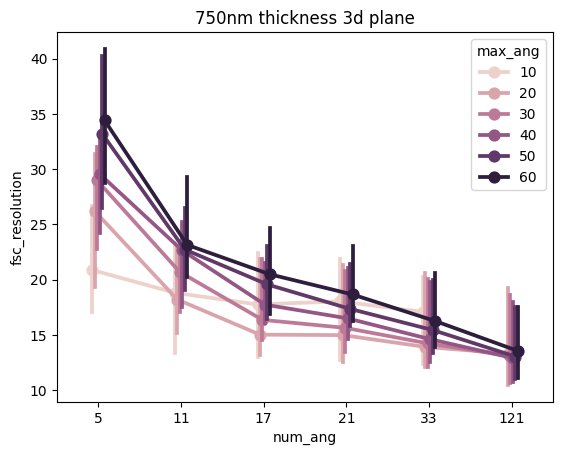

In [ ]:
thickness = '750nm'
plane = '3d'
#my_df = my_df[my_df['z'] == 50]
my_df = all_fsc[all_fsc['thickness']==thickness]
my_df = my_df[my_df['plane']==plane]
my_df = my_df[my_df['plane']==plane]
g= sns.pointplot(my_df,x='num_ang', y = 'fsc_resolution', hue='max_ang',  estimator='median',errorbar=('pi',50), dodge = True)
#g.set_yscale("log")
plt.title('%s thickness %s plane' % (thickness, plane))

/var/folders/vt/w6ggr1fn7ys7zyrbpq3d7ls5gbhsxz/T/ipykernel_6496/2262784775.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  my_df.dropna(subset=['correlation'], inplace=True)


Text(0.5, 1.0, '500nm thickness')

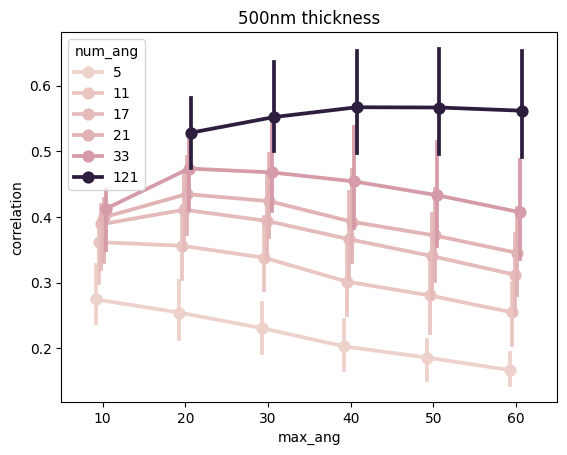

In [ ]:
thickness = '500nm'
num_angs = 33
#max_ang = 40
my_df = all_fsc[all_fsc['thickness']==thickness]
#my_df = my_df[my_df['num_ang']==num_ang]
my_df.dropna(subset=['correlation'], inplace=True)
#g= sns.pointplot(my_df,x='max_ang', y = 'fsc_resolution',hue='num_ang',estimator='median',errorbar=('pi',50), dodge = True)
g= sns.pointplot(my_df,x='max_ang', y = 'correlation',hue='num_ang',estimator='median',errorbar=('pi',50), dodge = True)
#g.set_yscale("log")
plt.title('%s thickness' % (thickness))

In [ ]:
thickness = '500nm'
plane = '3D'
my_df = all_fsc[all_fsc['thickness']==thickness]
my_df = my_df[my_df['plane']==plane]
g= sns.pointplot(my_df,x='num_ang', y = 'fsc_resolution', hue='max_ang',  estimator='median',errorbar=('pi',50), dodge = True)
#g.set_yscale("log")
plt.title('%s thickness %s plane' % (thickness, plane))

Text(0.5, 1.0, '500nm thick')

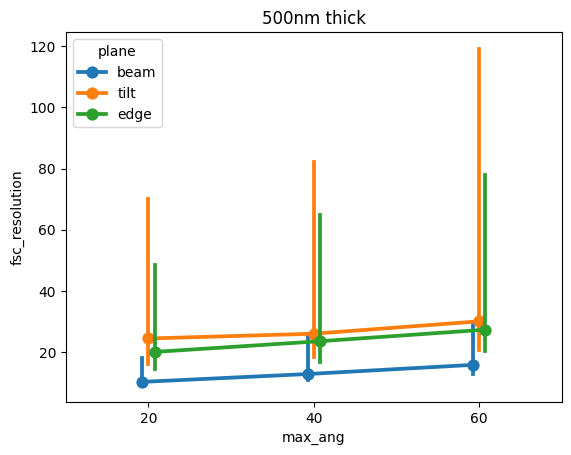

In [ ]:
thickness = '500nm'
num_ang = 33
my_df = all_fsc[all_fsc['thickness']==thickness]
my_df = my_df[my_df['num_ang']==num_ang]
sns.pointplot(all_fsc[all_fsc['thickness']==thickness],x='max_ang', y = 'fsc_resolution', hue='plane', estimator='median',errorbar=('pi',50), dodge = True)
plt.title('%s thick' % thickness)

Text(0.5, 1.0, '+-30 deg range')

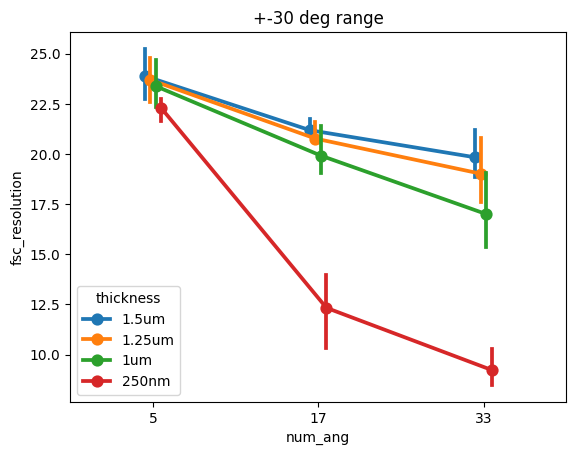

In [ ]:
all_fsc.dropna(inplace=True)
max_ang = 30
sns.pointplot(all_fsc[all_fsc['max_ang']==max_ang],x='num_ang', y = 'fsc_resolution', hue='thickness', errorbar=('pi',50), dodge = True)
plt.title('+-%i deg range' % max_ang)


Text(0.5, 1.0, '250nm thick')

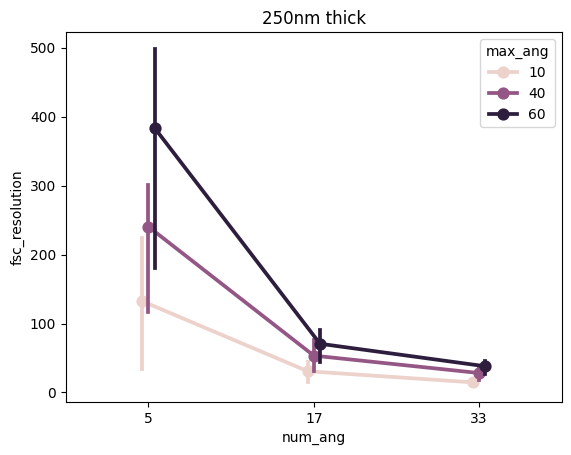

In [ ]:
thickness = '250nm'
sns.pointplot(all_fsc[all_fsc['thickness']==thickness],x='num_ang', y = 'fsc_resolution', hue='max_ang', errorbar=('pi',50), dodge = True)
#sns.violinplot(all_fsc[all_fsc['thickness']==thickness],x='num_ang', y = 'fsc_resolution', hue='max_ang')

plt.title('%s thick' % thickness)

In [ ]:
all_fsc[all_fsc['thickness']=='250nm']

,z,x,y,res,mean,thickness,pixel_size,name,num_ang,max_ang,fsc_resolution


Text(0.5, 1.0, '33 angles')

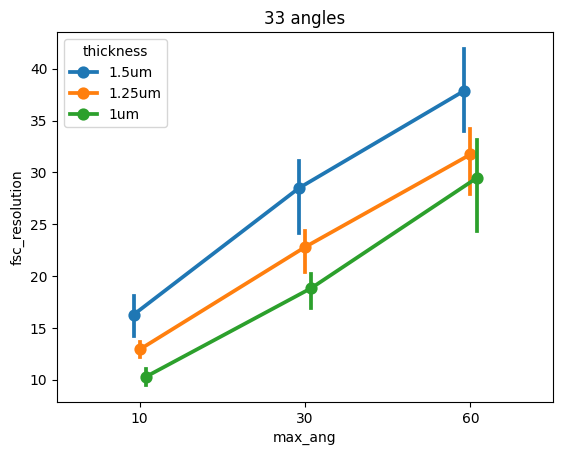

In [ ]:
num_angs = 33
sns.pointplot(all_fsc[all_fsc['num_ang']==num_angs],x='max_ang', y = 'fsc_resolution', hue='thickness', errorbar=('pi',50), dodge = True)
plt.title('%i angles' % num_angs)